<a href="https://colab.research.google.com/github/NoorFatimaMemon/DeepLearning/blob/main/21_TransferLearningwithTF/Transfer_Learning_and_Fine_Tuning_on_Flower_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

# Download the flower dataset from TensorFlow Datasets

In [2]:
import tensorflow_datasets as tfds

# Load the dataset

In [3]:
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

# Split the dataset into training, validation, and test sets

In [4]:
train_dataset = dataset['train'].take(3000)  # First 300 samples for training
validation_dataset = dataset['train'].skip(3000).take(200)  # Next 50 for validation
test_dataset = dataset['train'].skip(3200).take(200)  # Last 50 for testing

In [5]:
# Get one batch of images and labels
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (333, 500, 3)
Label batch shape: ()


# Preprocessing the dataset (resize and batch)

In [6]:
BATCH_SIZE = 64
IMG_SIZE = (160, 160)

def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

train_dataset = train_dataset.map(format_image).batch(BATCH_SIZE).shuffle(100)
validation_dataset = validation_dataset.map(format_image).batch(BATCH_SIZE)
test_dataset = test_dataset.map(format_image).batch(BATCH_SIZE)

# Display first few images and labels


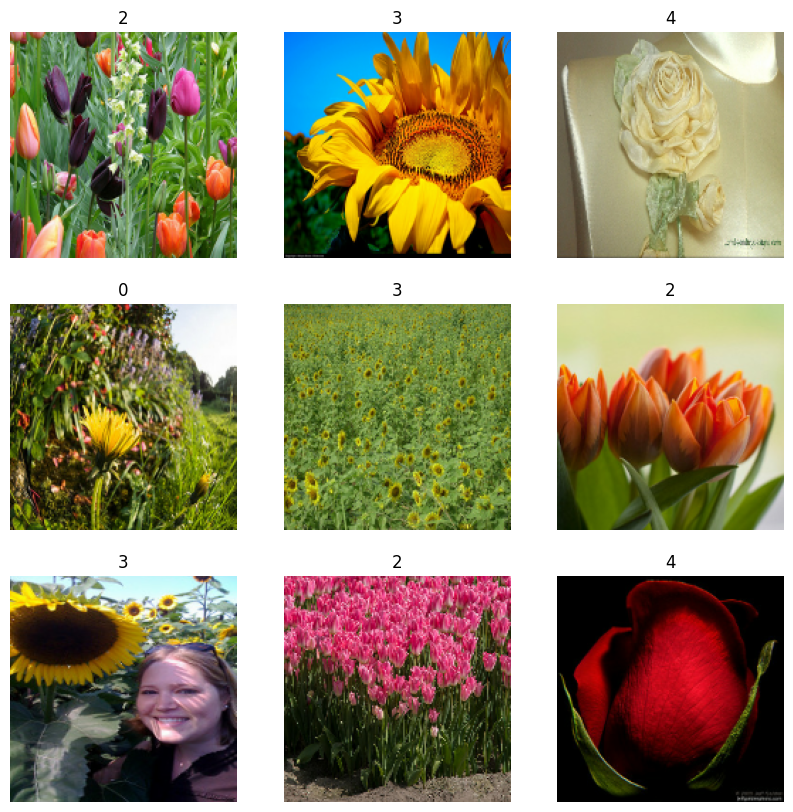

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(int(labels[i]))  # Labels are in numerical format
        plt.axis("off")

# Load pre-trained MobileNetV2 model, excluding the top layers (use as a feature extractor)


In [8]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')

In [9]:
# Freeze the base model (do not train its weights initially)
base_model.trainable = False

# data augmentation layers

In [10]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'), tf.keras.layers.RandomRotation(0.2),
                                         tf.keras.layers.RandomZoom(0.2), tf.keras.layers.RandomContrast(0.2),
                                         tf.keras.layers.RandomBrightness(0.2)])

# Add a new classification head on top of the frozen base model

In [11]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)  # Preprocess input
x = base_model(x, training=False)  # feature extraction
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # to reduce data size (spatial dimensions) while retaining important features.
x = tf.keras.layers.Dropout(0.3)(x)  # Dropout for regularization
outputs = tf.keras.layers.Dense(5)(x)  # 5 output units for the flower categories

In [12]:
model = tf.keras.Model(inputs, outputs)

# Compile the model

In [13]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model for a few epochs


In [14]:
initial_epochs = 10
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.1913 - loss: 1.8114 - val_accuracy: 0.1850 - val_loss: 1.6458
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.2092 - loss: 1.7247 - val_accuracy: 0.1850 - val_loss: 1.6586
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.2177 - loss: 1.7052 - val_accuracy: 0.1900 - val_loss: 1.6730
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.2408 - loss: 1.6541 - val_accuracy: 0.2200 - val_loss: 1.6093
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.2038 - loss: 1.6652 - val_accuracy: 0.1950 - val_loss: 1.6121
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.2265 - loss: 1.6483 - val_accuracy: 0.2100 - val_loss: 1.6062
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.2254 - loss: 1.6453 - val_accuracy: 0.1850 - val_loss: 1.6185
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.2338 - loss: 1.6307 - val_accuracy: 0.1850 - val_lo

# Plot the learning curves

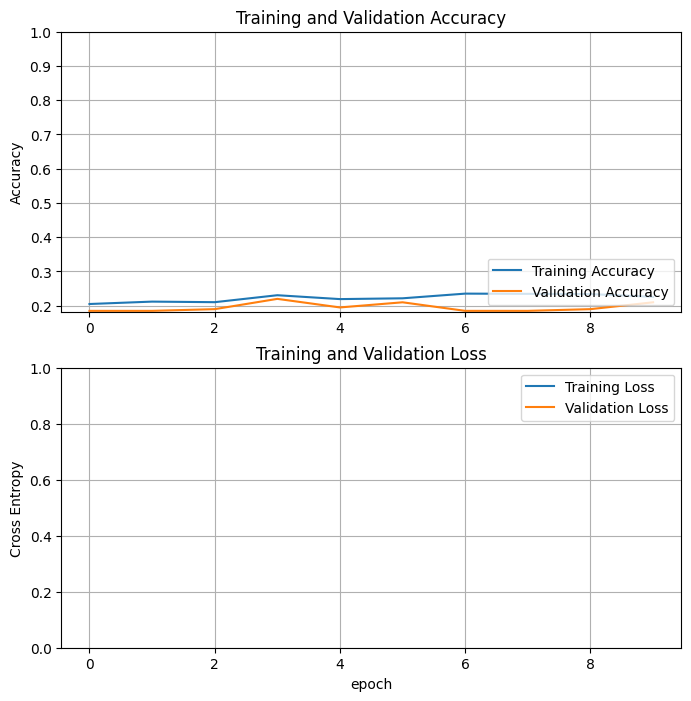

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()

plt.show()

# fine-tuning

In [16]:
base_model.trainable = True   # Unfreeze the top layers

In [17]:
# freeze all layers except the last few
fine_tune_at = 100  # Unfreeze from this layer onwards

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fine-tune the model

In [19]:
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.2288 - loss: 1.8344 - val_accuracy: 0.1950 - val_loss: 1.8258
Epoch 11/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.2397 - loss: 1.6641 - val_accuracy: 0.2650 - val_loss: 2.0177
Epoch 12/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.2825 - loss: 1.6172 - val_accuracy: 0.2050 - val_loss: 2.2226
Epoch 13/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.2956 - loss: 1.5909 - val_accuracy: 0.2050 - val_loss: 2.1627
Epoch 14/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.2830 - loss: 1.5909 - val_accuracy: 0.2050 - val_loss: 2.6935
Epoch 15/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.3083 - loss: 1.5366 - val_accuracy: 0.2050 - val_loss: 2.7629


# Plot learning curves for fine-tuning

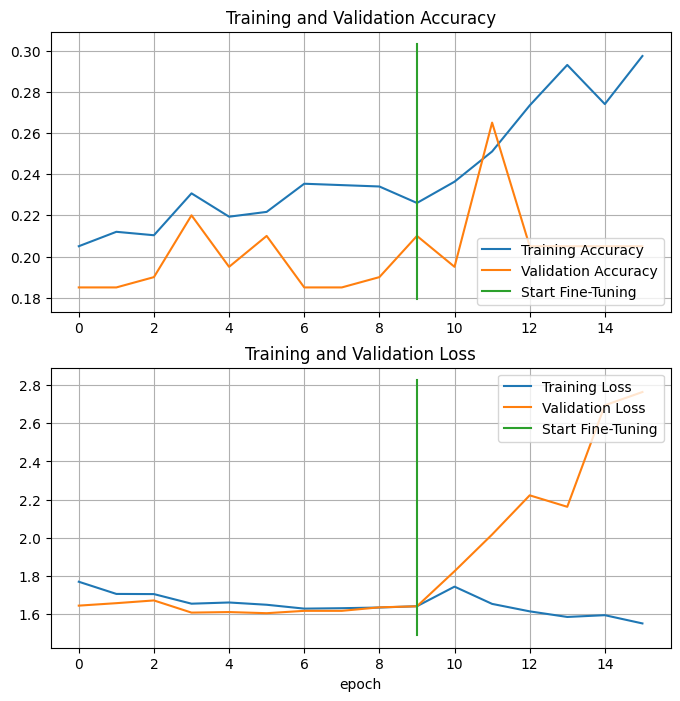

In [20]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()

plt.show()


# Evaluate the model

In [21]:
from sklearn.metrics import classification_report
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

print(classification_report(y_true, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.20      1.00      0.33        39
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        36
           4       0.00      0.00      0.00        44

    accuracy                           0.20       200
   macro avg       0.04      0.20      0.07       200
weighted avg       0.04      0.20      0.06       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Predictions on a batch of test images


In [22]:
image_batch, label_batch = next(iter(test_dataset))
predictions = model.predict(image_batch)
predicted_labels = np.argmax(predictions, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


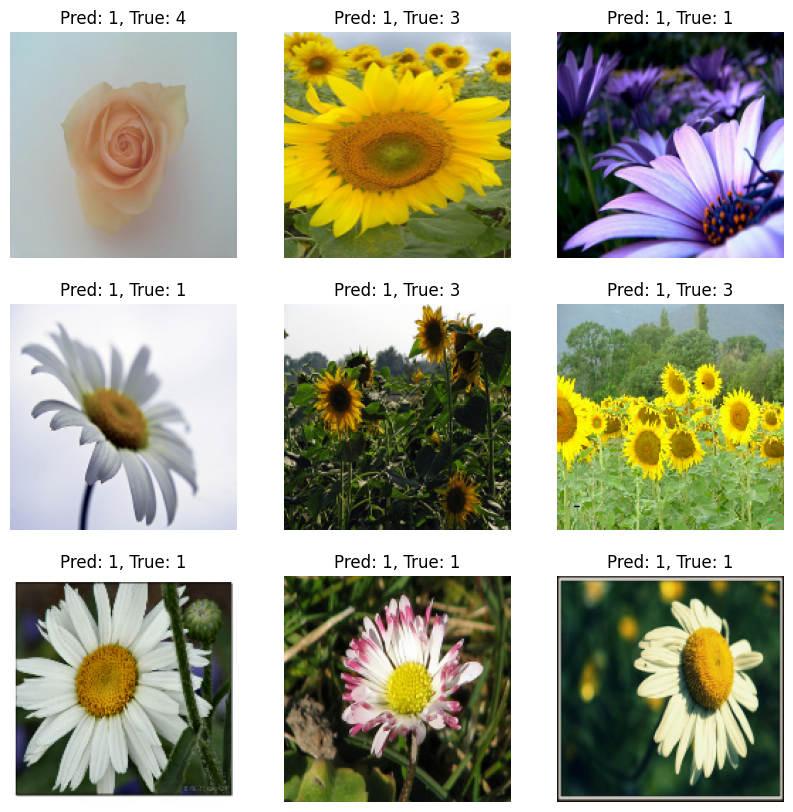

In [23]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy())
    plt.title(f"Pred: {predicted_labels[i]}, True: {label_batch[i]}")
    plt.axis("off")